# Notebook 5:  Everest Expedition EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

In [2]:
everest_posted = pd.read_csv('data/everest_posted.csv')
everest_actl = pd.read_csv('data/everest_actl.csv')

In [3]:
everest_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [4]:
everest_posted['date'] = pd.to_datetime(everest_posted['date'])
everest_posted['datetime'] = pd.to_datetime(everest_posted['datetime'])
everest_posted['day_name'] = everest_posted.day_name.astype('string')

everest_actl['date'] = pd.to_datetime(everest_actl['date'])
everest_actl['datetime'] = pd.to_datetime(everest_actl['datetime'])


# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
everest_date = everest_posted.copy()
everest_date.set_index('date', inplace=True)


everest_dt = everest_posted.copy()
everest_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = everest_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid_daily = everest_posted.copy()
covid_daily['date2'] = covid_daily['date']
covid_daily = covid_daily[covid_daily['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = everest_posted.copy()
precovid = precovid[precovid['date'] < '2020-01-03']

everest_posted.set_index('date', inplace = True)
everest_actl.set_index('date', inplace = True)

# EDA - Everest Expedition

## Overview

The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since Ride Opened

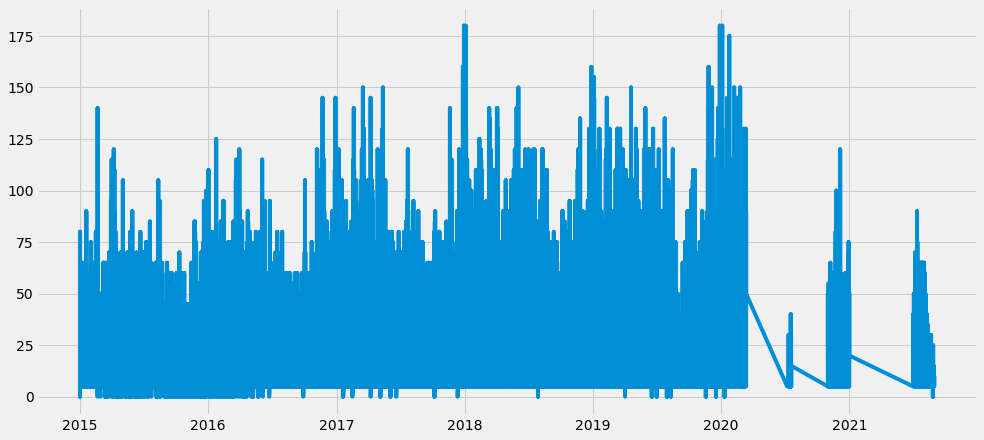

In [5]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(everest_posted['SPOSTMIN']);

In [6]:
print(f"Minimum Wait: {everest_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {everest_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 180.0


Because of missing data and the covid closure (March 15 - July 11, 2020), I want to separate the precovid data from the covid data.

In [7]:
precovid_daily.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01
1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday,2015-01-01
2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday,2015-01-01
3,2015-01-01,2015-01-01 08:12:23,NaN,5.0,4,Thursday,2015-01-01
4,2015-01-01,2015-01-01 08:19:26,NaN,5.0,4,Thursday,2015-01-01


In [8]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2020-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='first')
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01,40.268817
2015-01-02,2015-01-02 07:47:24,NaN,5.0,5,Friday,2015-01-02,34.198113
2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday,2015-01-03,29.793814
2015-01-04,2015-01-04 07:40:27,NaN,5.0,7,Sunday,2015-01-04,23.850000
2015-01-05,2015-01-05 08:47:22,NaN,5.0,1,Monday,2015-01-05,26.956522


In [9]:
# Limit data to covid
covid_daily = covid_daily[covid_daily.date2 > '2020-01-01']
covid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_wait
covid_daily['avg_daily_wait'] = covid_daily.groupby('date2')['SPOSTMIN'].mean()
covid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')
covid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01,40.268817
2015-01-02,2015-01-02 07:47:24,NaN,5.0,5,Friday,2015-01-02,34.198113
2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday,2015-01-03,29.793814
2015-01-04,2015-01-04 07:40:27,NaN,5.0,7,Sunday,2015-01-04,23.850000
2015-01-05,2015-01-05 08:47:22,NaN,5.0,1,Monday,2015-01-05,26.956522


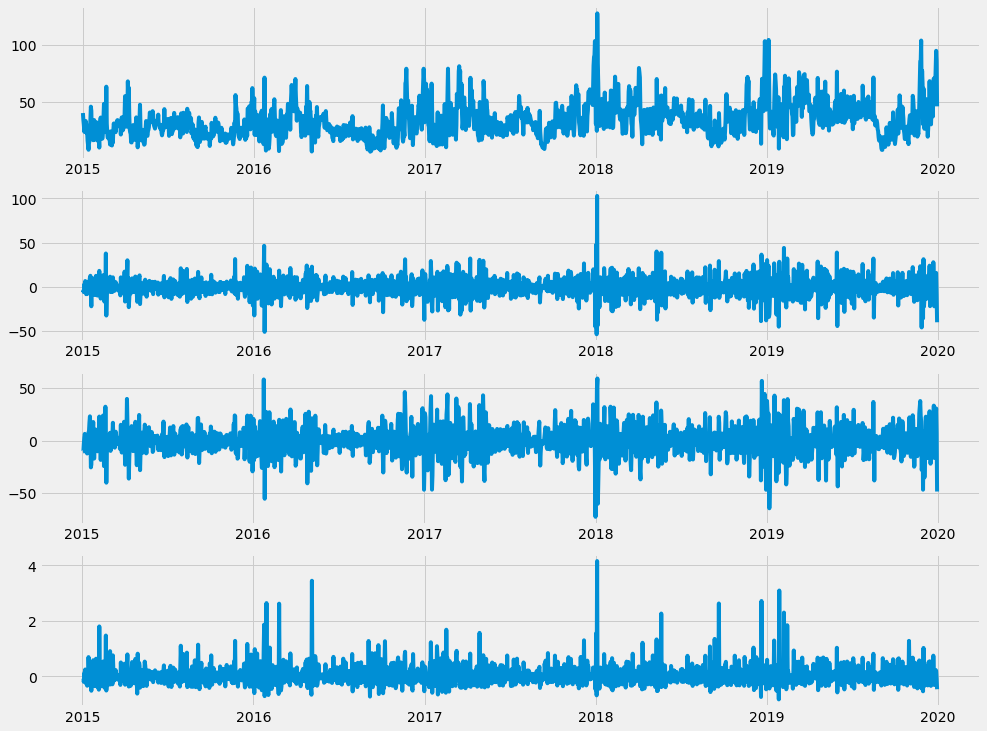

In [10]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

None of these plots look much different from each other.  The percent change plot shows some curious spikes that aren't always seasonal.

Given the lack of stationarity in the plots above, and given the nature of Disney's business, I need to explore the data for hourly "seasonality," weekly "seasonality," and possibly monthly "seasonality."

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.

In [11]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       35.610679
Monday       34.807007
Saturday     38.799981
Sunday       36.211735
Thursday     32.592286
Tuesday      31.164348
Wednesday    28.880589
Name: avg_daily_wait, dtype: float64

Average daily wait time for the Everest Expedition was just over an hour before COVID.  Based on this summary, Wednesdays have the shortest average wait and Saturdays have the longest.  However, when ride waits exceed 1 hour, do 8 minutes make a substantial, qualitative difference to riders?  Or are they more likely to opt out or buy an individual Lightning Lane pass to skip the line?

## Hourly Seasonality

Is there a time of day when the ride has significantly shorter or longer wait times?  I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [12]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

everest_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
everest_Wed_Dec_05.set_index('datetime', inplace = True)

In [13]:
print(f"Minimum wait: {everest_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {everest_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 45.0


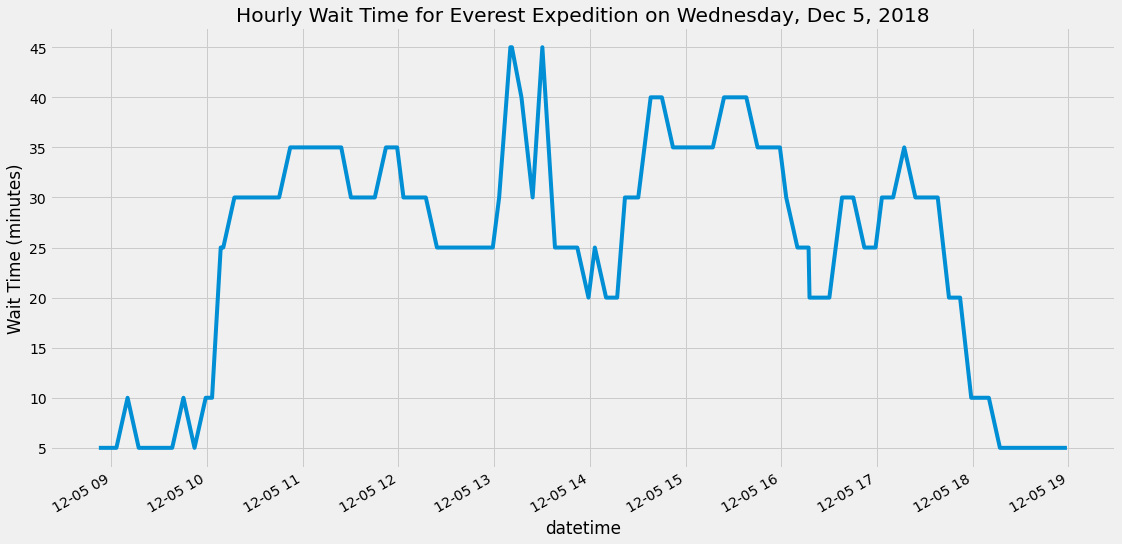

In [14]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Everest Expedition on Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

everest_Wed_Dec_05['SPOSTMIN'].plot();

If guests don't want to purchase an individual Lightning Lane pass for this ride, they should arrive at the park early and ride it first.  The wait time in the evening goes down also, but staff close the ride entrance before the park closes, so that riders are off the ride by closing time.  Remember, this is a lower-volume Wednesday.

In [15]:
# Step 3: Create data for Saturday, Dec 8, 2018

everest_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
everest_Sat_Dec_08.set_index('datetime', inplace = True)

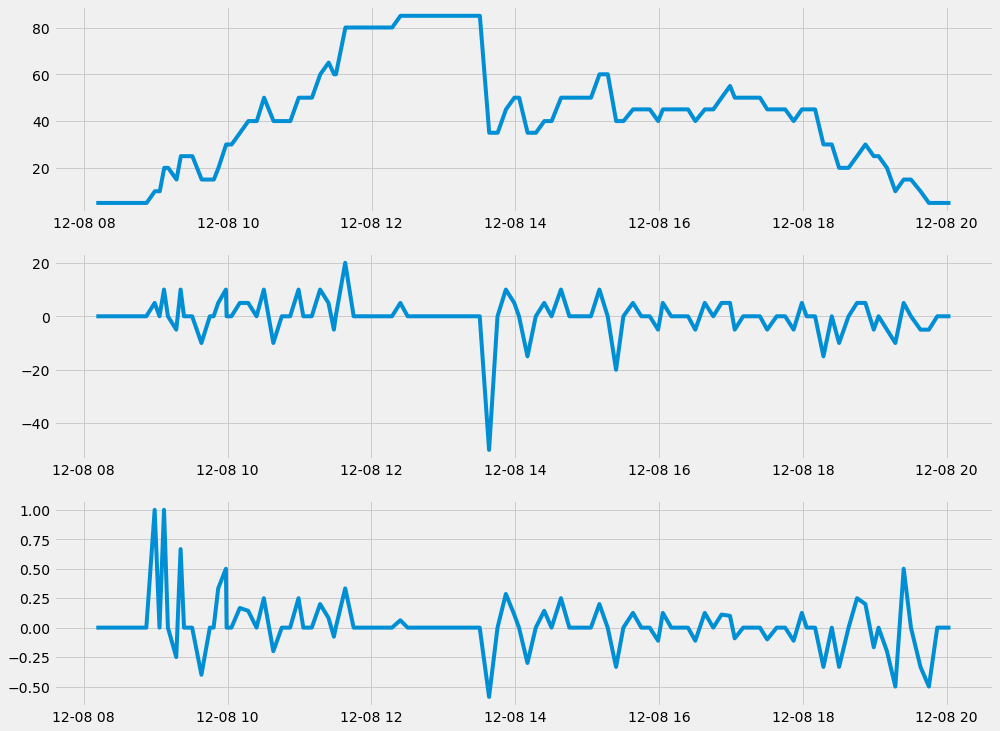

In [16]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(everest_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(everest_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(everest_Sat_Dec_08['SPOSTMIN'].pct_change());

In [17]:
print(f"Minimum wait: {everest_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {everest_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 85.0


The two hourly plots differ substantially.  The Wednesday plot shows thw wait time spiking shortly after the ride opens and remaining long until shortly before the ride closes.  The Saturday plot has several ebbs and flows, including two (around 10AM and 5-5:30PM) when the wait time drops to about 50 minutes.  Is this typical for Saturdays?  Or is this just the pattern on this particular Saturday?

The second and third subplots show differenced data and percent change data respectively.  The differenced data still show the dips evident in the original data.  The bottom two subplots look very similar.  The data are not stationary for Saturday, Dec 8, 2018.

In [18]:
# Step 5: Create df for Saturdays only
everest_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()
saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays = saturdays.groupby('date')

In [19]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
199,2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday
200,2015-01-03,2015-01-03 07:54:25,NaN,5.0,6,Saturday
201,2015-01-03,2015-01-03 08:05:24,NaN,5.0,6,Saturday
202,2015-01-03,2015-01-03 08:12:23,NaN,5.0,6,Saturday
203,2015-01-03,2015-01-03 08:19:29,NaN,5.0,6,Saturday
...,...,...,...,...,...,...
190268,2019-12-28,2019-12-28 08:31:02,NaN,10.0,6,Saturday
190269,2019-12-28,2019-12-28 09:45:02,NaN,10.0,6,Saturday
190270,2019-12-28,2019-12-28 09:52:02,NaN,45.0,6,Saturday
190271,2019-12-28,2019-12-28 09:59:02,NaN,90.0,6,Saturday


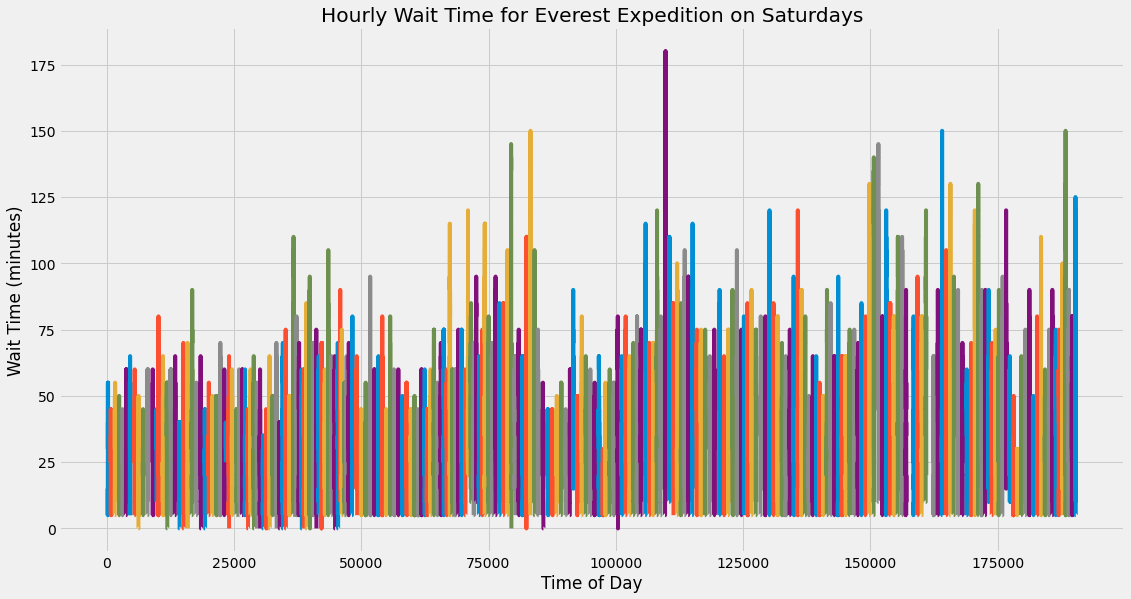

In [20]:
# Step 6: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Everest Expedition on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

There might be some hourly seasonality for Saturdays, but it's very difficult to tell in this plot.  I'll revisit this in the SARIMAX model.

## Weekly Seasonality

In [21]:
# copy dataframe
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# delete duplicates before indexing
precovid_weekly.drop_duplicates(subset='week_num', keep = 'first', inplace=True)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()
precovid_weekly.shape

(260, 9)

In [22]:
# verify it worked
precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,avg_weekly_wait
week_num,,,,,,,,,
0,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01,40.268817,0,40.268817
1,2015-01-08 09:07:08,NaN,5.0,4,Thursday,2015-01-08,30.846154,7,30.846154
2,2015-01-15 09:05:07,NaN,5.0,4,Thursday,2015-01-15,15.891089,14,15.891089
3,2015-01-22 08:45:06,NaN,5.0,4,Thursday,2015-01-22,19.714286,21,19.714286
4,2015-01-29 10:10:02,NaN,15.0,4,Thursday,2015-01-29,19.634146,28,19.634146


In [23]:
# copy dataframe for backup
covid_weekly = covid_daily.copy()

# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
covid_weekly_2 = covid_weekly.copy()

covid_weekly['week_number'] = covid_weekly['week_num']

# Group waiting times by date to get avg_daily_posted_wait
covid_weekly['avg_daily_wait'] = covid_weekly.groupby('date2')['SPOSTMIN'].mean()

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()

covid_weekly['date'] = covid_weekly['date2']

# set index to date
covid_weekly.set_index('date', inplace=True)

# delete duplicates
covid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

covid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2015-01-07,2015-01-07 08:00:36,NaN,5.0,3,Wednesday,2015-01-07,5.0,6,0,5.000000
2015-01-14,2015-01-14 07:50:06,NaN,5.0,3,Wednesday,2015-01-14,5.0,13,1,5.000000
2015-01-21,2015-01-21 07:50:06,NaN,5.0,3,Wednesday,2015-01-21,5.0,20,2,5.000000
2015-01-28,2015-01-28 08:56:58,NaN,20.0,3,Wednesday,2015-01-28,20.0,27,3,7.142857
2015-02-04,2015-02-04 07:50:05,NaN,5.0,3,Wednesday,2015-02-04,5.0,34,4,6.428571


# Modeling

### Null Model

In [24]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

34.36388340567682

Compared to the other rides, this wait time is pretty short.  If you've already purchased Genie+ for Flight of Passage, then you may as well save 25 min (there's always a short wait, even with a special pass).  If you're not interested in Flight of Passage, you might just want to skip Genie+ and stand in line for Everest Expedition.  It's a fun roller coaster that goes forwards and backwards.

### Weekly EDA

In [25]:
precovid_weekly['date'] = precovid_weekly['date2']
precovid_weekly.set_index('date2', inplace=True)

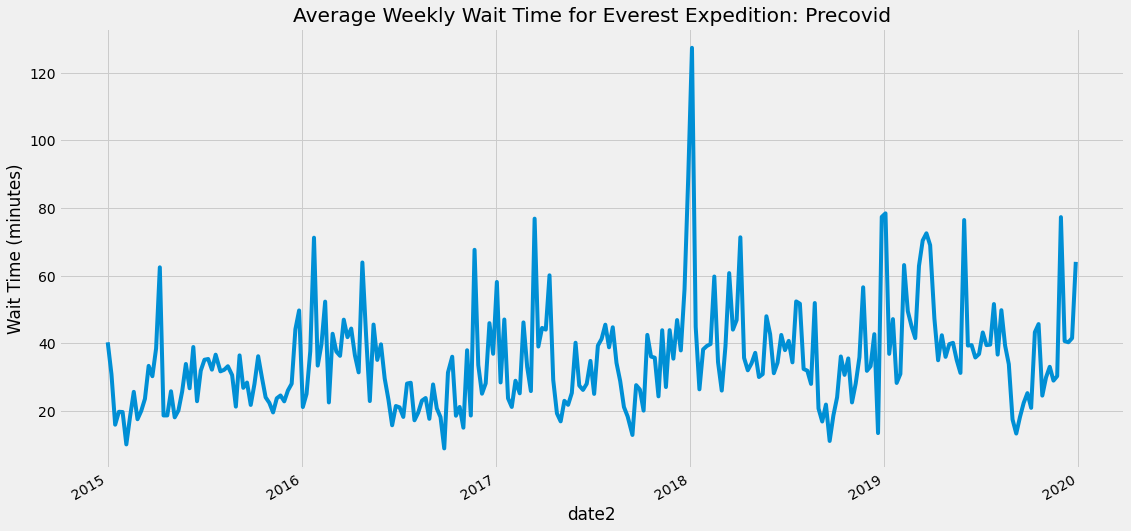

In [26]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Everest Expedition: Precovid")
plt.xlabel('Year')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

There is some seasonality here.  I'm unsure why Dec, 2018 spiked so much more than December of other years. The same thing happened with Kiliminjaro Safaris.

##  Weekly ACF and PACF Plots

In [27]:
precovid_weekly.shape

(260, 9)

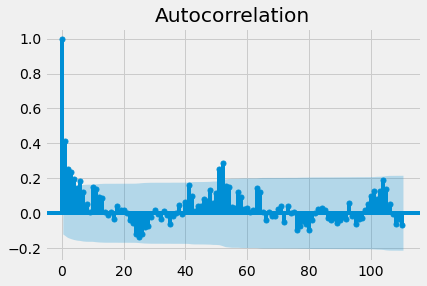

In [28]:
# Weekly ACF plot for pre-covid
plot_acf(precovid_weekly['avg_weekly_wait'], lags=110)
plt.show()

There is cyclical autocorrelation.

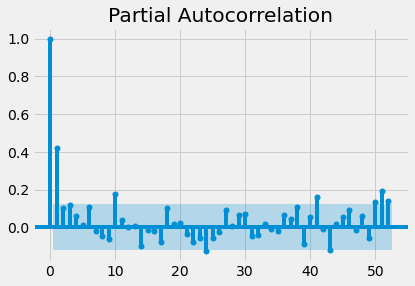

In [29]:
# Weekly PACF plot for  pre-covid
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=52)
plt.show()

There's substantial partial autocorrelation during the first two intervals, as expected.  There's marginal partial autocorrelation over the course of the year, particularly at intervals 10, 24, 38, 41, and 50-52.

### 90 Day ACF and PACF Plots

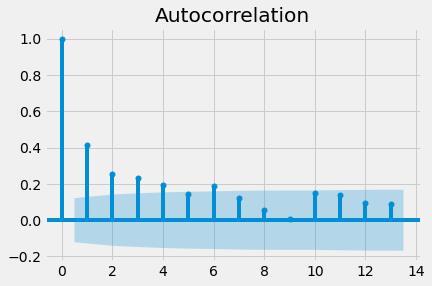

In [30]:
# 13 Week plot beginning (roughly 3 months)
plot_acf(precovid_weekly['avg_weekly_wait'], lags=13)
plt.show()

There's autocorrelation for the first 6 intervals (approximately 6 weeks) and marginal autocorrelation for weeks 10-11.

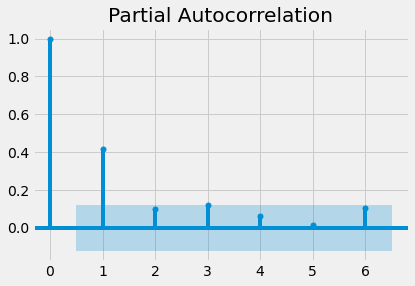

In [31]:
# 13 Week plot beginning  (roughly 3 months)
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=6)
plt.show()

In [32]:
precovid_weekly.dtypes

datetime           datetime64[ns]
SACTMIN                   float64
SPOSTMIN                  float64
weekday                     int64
day_name                   string
avg_daily_wait            float64
day_num                     int64
avg_weekly_wait           float64
date               datetime64[ns]
dtype: object

In [33]:
precovid_weekly_3 = precovid_weekly[['avg_weekly_wait']]
precovid_weekly_3

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date2,
2015-01-01,40.268817
2015-01-08,30.846154
2015-01-15,15.891089
2015-01-22,19.714286
2015-01-29,19.634146
...,...
2019-11-28,70.590155
2019-12-05,45.859884
2019-12-12,40.326378


In [34]:
#model = pmd.auto_arima(precovid_weekly_3['avg_weekly_wait'], m=52, trace=True)

In [35]:
sarimax_model = sm.tsa.statespace.SARIMAX(precovid_weekly_3['avg_weekly_wait'], order=(1,1,2), seasonal_order=(1, 0, 1, 52))
everest_results = sarimax_model.fit()

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01268D+00    |proj g|=  5.10012D-02


 This problem is unconstrained.



At iterate    5    f=  4.00143D+00    |proj g|=  2.29401D-02

At iterate   10    f=  3.98960D+00    |proj g|=  6.93641D-03

At iterate   15    f=  3.98886D+00    |proj g|=  3.54670D-03

At iterate   20    f=  3.98842D+00    |proj g|=  2.80494D-03

At iterate   25    f=  3.98565D+00    |proj g|=  6.66751D-03

At iterate   30    f=  3.98021D+00    |proj g|=  3.31598D-03

At iterate   35    f=  3.98013D+00    |proj g|=  3.61843D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   1.913D-05   3.980D+00
  F =   3.9801316046968589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [36]:
# print summary of fit model
print(everest_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      avg_weekly_wait   No. Observations:                  260
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 52)   Log Likelihood               -1034.834
Date:                              Mon, 25 Oct 2021   AIC                           2081.668
Time:                                      10:11:10   BIC                           2103.009
Sample:                                           0   HQIC                          2090.249
                                              - 260                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7415      0.150      4.930      0.000       0.447       1.036
ma.L1         -1.49

In [37]:
print(f'Mean absolute error: {everest_results.mae}')
print(f'Mean squared error: {everest_results.mse}')

Mean absolute error: 9.304228453554428
Mean squared error: 175.7383674112959


The error metrics are pretty low.

In [38]:
# Are the data stationary?  Here's an adfuller test:

adfuller(precovid_weekly_3['avg_weekly_wait'])

(-6.1031060061819735,
 9.728265902120385e-08,
 2,
 257,
 {'1%': -3.4560535712549925,
  '5%': -2.8728527662442334,
  '10%': -2.5727985212493754},
 1970.449806298116)

With an alpha of .05 and a p-value of .0000000973, the data are stationary.

# Pickle

In [39]:
with open('models/everest_results.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(everest_results, pickle_out)

## Predict Wait Times

In [40]:
# Create Train-Test split
train, test = train_test_split(precovid_weekly['avg_weekly_wait'],
                                  test_size = 0.2,
                                  shuffle = False)

In [46]:
covid_weekly_3 = covid_weekly[['avg_weekly_wait', 'week_number', 'date2']]
covid_weekly_3.head()

,avg_weekly_wait,week_number,date2
date,,,
2015-01-07,5.000000,0,2015-01-07
2015-01-14,5.000000,1,2015-01-14
2015-01-21,5.000000,2,2015-01-21
2015-01-28,7.142857,3,2015-01-28
2015-02-04,6.428571,4,2015-02-04


In [47]:
# Predictions
start_index = 0
end_index = len(covid_weekly_3)

forecast = everest_results.predict(start=start_index, end=end_index)
forecast

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


0       0.000000
1      40.263504
2      35.062614
3      26.896994
4      24.667757
         ...    
256    45.922712
257    44.287311
258    40.694692
259    58.671771
260    65.215820
Name: predicted_mean, Length: 261, dtype: float64

In [48]:
predictions = pd.DataFrame(forecast)
predictions.rename(columns={predictions.columns[0]:'preds'}, inplace=True)

predictions.head()

,preds
0,0.000000
1,40.263504
2,35.062614
3,26.896994
4,24.667757


In [58]:
covid_weekly_3 = covid_weekly_3.set_index('week_number')

In [59]:
df_final = covid_weekly_3.join(predictions, how='outer')

In [60]:
df_final

,avg_weekly_wait,date2,preds
0,5.000000,2015-01-07,0.000000
1,5.000000,2015-01-14,40.263504
2,5.000000,2015-01-21,35.062614
3,7.142857,2015-01-28,26.896994
4,6.428571,2015-02-04,24.667757
...,...,...,...
256,5.714286,2019-12-12,45.922712
257,9.285714,2019-12-19,44.287311
258,5.714286,2019-12-26,40.694692
259,12.000000,2019-12-31,58.671771


In [61]:
df_final['resids'] = df_final['preds'] - df_final['avg_weekly_wait']

In [62]:
df_final.mean()

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_12693/2405253595.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_final.mean()


avg_weekly_wait     6.079121
preds              34.276653
resids             28.078536
dtype: float64

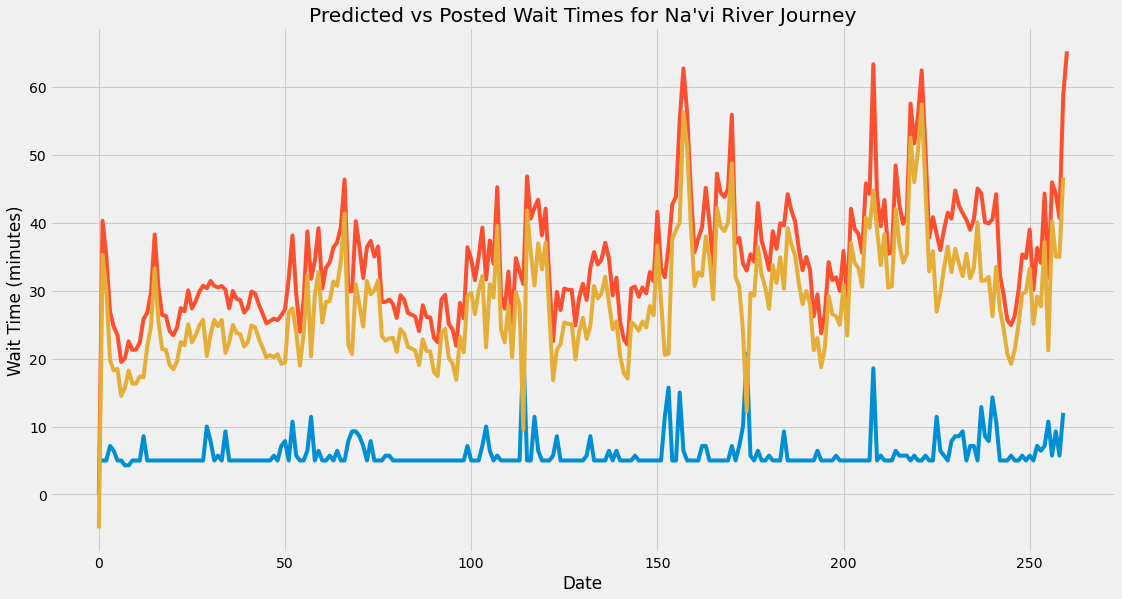

In [64]:
plt.figure(figsize = (17, 9))
plt.title("Predicted vs Posted Wait Times for Na'vi River Journey")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')

df_final['avg_weekly_wait'].plot()
df_final['preds'].plot()
df_final['resids'].plot()
plt.legend;

In [65]:
covid_weekly_3.to_csv('data/everest_covid_weekly3.csv', index=True)